# Review Supervised Learning: Comparing Classifiers

In this exercise, we review all classifiers we have learned so far, and test their performance on the 20-newsgroups dataset. 

Let's import all models.

In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Let's import the dataset. We use the keyword argument `categories=[...]` to limit our dataset. Omit this argument to load all twenty newsgroups.

In [122]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
print newsgroups.target_names 
print len(newsgroups.data), 'newsgroups articles in', len(newsgroups.target_names), 'groups'

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
2034 newsgroups articles in 4 groups


The newsgroup articles are stored in `newsgroups.data`. These are actual messages.

The target variables that we want to predict are in `newsgroups.target`. The number in `target` specifies the actual newsgroup in the `target_names`.

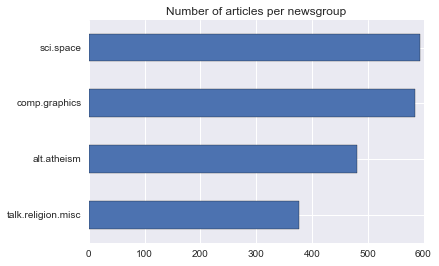

In [123]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

y = newsgroups.target
groups = pd.Series(newsgroups.target_names)
f = groups[y].value_counts(ascending=True).plot(kind='barh', title="Number of articles per newsgroup")

Since we're processing text, we need vectorizers that transform our text features into a usable feature matrix we can feed into our models. You could use `CountVectorizer` or `TfidfVectorizer`, which we both explained in more detail in [20_newsgroups.ipynb](../11_bayes/20_newsgroups.ipynb). 

Feel free to **try out different options**, such as `ngram_range=(0,3)`.

In [124]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()  # or TfidfVectorizer, or different options
X = cv.fit_transform(newsgroups.data)

Fit the model and measure cross-validated accuracy, or AUC. Feel free to **try out different options here** as well, such as the regularization parameter, kernels, etc.

### K-Fold CV

http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html

In [126]:
from sklearn.cross_validation import train_test_split, cross_val_score, KFold

num_instances = len(newsgroups.data)
num_folds = 5

print "Applying KFold cross-validation with %i folds across %i samples" % (num_folds, num_instances)
print

folds = KFold(num_instances, n_folds=num_folds)

i = 0
scores = []
for train_idxs, test_idxs in folds:
    print "Fold: ", i
    print "\tTraining indexes:", train_idxs.min(), "-", train_idxs.max()
    print "\tTest indexes:", test_idxs.min(), "-", test_idxs.max()
    i += 1
    
    X_train, X_test = X[train_idxs], X[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]
    
    model = KNeighborsClassifier(n_neighbors=50)
    model.fit(X_train, y_train)
    
    score = model.score(X_test, y_test)
    scores.append(score)
    
    print "\tKNN Model (50 neighbors) Score: ", score
    print

print
print "MEAN SCORE:", sum(scores) / len(scores)

Applying KFold cross-validation with 5 folds across 2034 samples

Fold:  0
	Training indexes: 407 - 2033
	Test indexes: 0 - 406
	KNN Model (50 neighbors) Score:  0.584766584767

Fold:  1
	Training indexes: 0 - 2033
	Test indexes: 407 - 813
	KNN Model (50 neighbors) Score:  0.552825552826

Fold:  2
	Training indexes: 0 - 2033
	Test indexes: 814 - 1220
	KNN Model (50 neighbors) Score:  0.560196560197

Fold:  3
	Training indexes: 0 - 2033
	Test indexes: 1221 - 1627
	KNN Model (50 neighbors) Score:  0.601965601966

Fold:  4
	Training indexes: 0 - 1627
	Test indexes: 1628 - 2033
	KNN Model (50 neighbors) Score:  0.581280788177


MEAN SCORE: 0.576207017586


**The above code is equivalent to:**

In [127]:
model = KNeighborsClassifier(n_neighbors=50)
print "Mean Score", cross_val_score(model, X, y, scoring='accuracy').mean()

Mean Score 0.559010378995


Obviously you can do better than that.

### Grid Search over many values of k, using both 'uniform' and 'distance' weighting

In [128]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

parameter_grid = [
  {
        'n_neighbors': range(2, 70),
        'weights': ['uniform', 'distance']
  }
 ]

clf = GridSearchCV(KNeighborsClassifier(), parameter_grid, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [129]:
print
print "GRID SEARCH RESULTS:"
print "\tBest Parameters", clf.best_params_
print "\tBest Score", clf.best_score_

# A list of all scores are stored in clf.grid_scores_
pd.DataFrame(clf.grid_scores_).head()


GRID SEARCH RESULTS:
	Best Parameters {'n_neighbors': 2, 'weights': 'distance'}
	Best Score 0.719287469287


,parameters,mean_validation_score,cv_validation_scores
0,"{u'n_neighbors': 2, u'weights': u'uniform'}",0.666462,"[0.648897058824, 0.675874769797, 0.674676524954]"
1,"{u'n_neighbors': 2, u'weights': u'distance'}",0.719287,"[0.661764705882, 0.756906077348, 0.739371534196]"
2,"{u'n_neighbors': 3, u'weights': u'uniform'}",0.678747,"[0.634191176471, 0.705340699816, 0.69685767098]"
3,"{u'n_neighbors': 3, u'weights': u'distance'}",0.705160,"[0.685661764706, 0.716390423573, 0.713493530499]"
4,"{u'n_neighbors': 4, u'weights': u'uniform'}",0.683047,"[0.691176470588, 0.672191528545, 0.685767097967]"


In [119]:
# Cleanup the dataframe so we can plot
scores_df = pd.DataFrame(columns=["n_neighbors", "weights", "score"])

for grid_score in clf.grid_scores_:
    scores_df = scores_df.append({
            "n_neighbors": grid_score.parameters["n_neighbors"], 
            "weights": grid_score.parameters["weights"], 
            "score": grid_score.mean_validation_score
        }, ignore_index=True)


scores_df["n_neighbors"] = scores_df["n_neighbors"].astype(np.int)
scores_df.head()

,n_neighbors,weights,score
0,2,uniform,0.666462
1,2,distance,0.719287
2,3,uniform,0.678747
3,3,distance,0.705160
4,4,uniform,0.683047


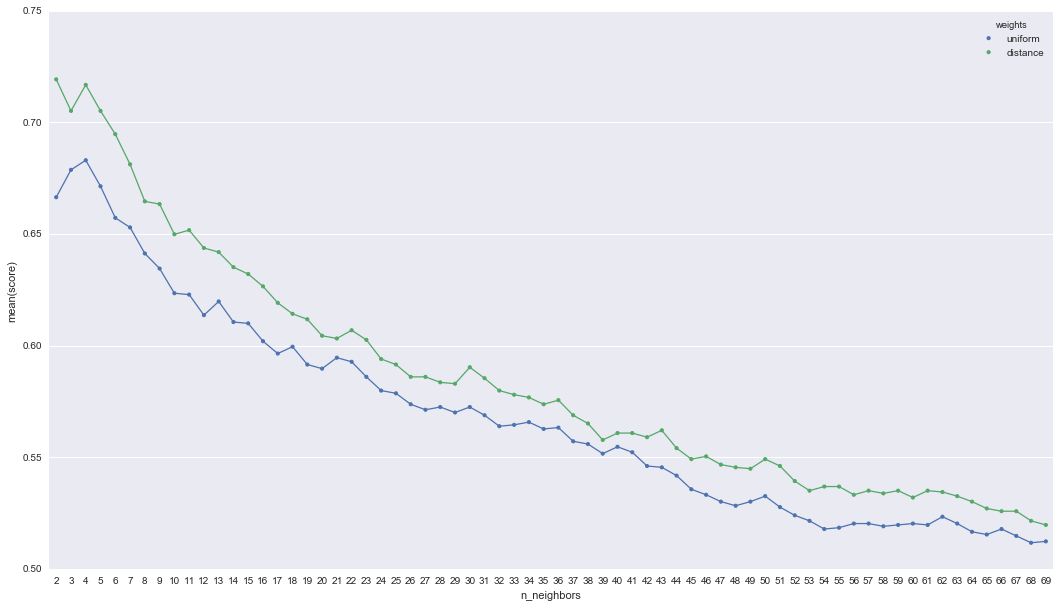

In [120]:
plt.figure(figsize=(18, 10))
sns.pointplot(data=scores_df, x="n_neighbors", y="score", hue="weights", scale=0.4);

## Exercise

1. Given the above distribution of newsgroups (the `y`s), what is reasonable accuracy to expect? What would a naive classier's (random guesser) accuracy be?
1. Try out different models, testing their cross-validated accuracy
1. Try out different options (such as regularization parameters, kernels, etc.)
1. Try out different text vectorizers and options
1. If you find a model you like, try different categories (or all of them) and see if this impacts your performance
1. Try to interpret its learned parameters and plot some nice insights

## Bonus
1. Evaluate all 4 models in a single step using GridSearch

For interpretation, recall that
- LogisticRegression gives you coefficients for the log odds of the corresponding feature
- Random Forests and Decision Trees give you feature importances

In [7]:
# Your code here